In [1]:
## Import packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

## Load data
tips = sns.load_da
taset('tips')
X = np.array(tips.drop(columns = 'tip'))
y = np.array(tips['tip'])

## Train-test split
np.random.seed(1)
test_frac = 0.25
test_size = int(len(y)*test_frac)
test_idxs = np.random.choice(np.arange(len(y)), test_size, replace = False)
X_train = np.delete(X, test_idxs, 0)
y_train = np.delete(y, test_idxs, 0)
X_test = X[test_idxs]
y_test = y[test_idxs]

In [2]:
def RSS_reduction(child_L, child_R, parent):
    rss_parent = sum((parent - np.mean(parent))**2)
    rss_child_L = sum((child_L - np.mean(child_L))**2) 
    rss_child_R = sum((child_R - np.mean(child_R))**2)
    return rss_parent - (rss_child_L + rss_child_R)

def sort_x_by_y(x, y):
    unique_xs = np.unique(x)
    y_mean_by_x = np.array([y[x == unique_x].mean() for unique_x in unique_xs])
    ordered_xs = unique_xs[np.argsort(y_mean_by_x)]
    return ordered_xs

def all_rows_equal(X):
    return (X == X[0]).all()

In [3]:
class Node:
    
    def __init__(self, Xsub, ysub, ID, depth = 0, parent_ID = None, leaf = True):
        self.ID = ID
        self.Xsub = Xsub
        self.ysub = ysub
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf
        
class Splitter:
    
    def __init__(self):
        self.rss_reduction = 0
        self.no_split = True
        
    def _replace_split(self, rss_reduction, d, dtype = 'quant', t = None, L_values = None):
        self.rss_reduction = rss_reduction
        self.d = d
        self.dtype = dtype
        self.t = t        
        self.L_values = L_values     
        self.no_split = False

In [5]:
class DecisionTreeRegressor:
    
    #############################
    ######## 1. TRAINING ########
    #############################
    
    ######### FIT ##########
    def fit(self, X, y, max_depth = 100, min_size = 2, C = None):
        
        ## Add data
        self.X = X
        self.y = y
        self.N, self.D = self.X.shape
        dtypes = [np.array(list(self.X[:,d])).dtype for d in range(self.D)]
        self.dtypes = ['quant' if (dtype == float or dtype == int) else 'cat' for dtype in dtypes]
        
        ## Add regularization parameters
        self.max_depth = max_depth
        self.min_size = min_size
        self.C = C
        
        ## Initialize nodes
        self.nodes_dict = {}
        self.current_ID = 0
        initial_node = Node(Xsub = X, ysub = y, ID = self.current_ID, parent_ID = None)
        self.nodes_dict[self.current_ID] = initial_node
        self.current_ID += 1
        
        ## Build
        self._build()
        
    ###### BUILD TREE ######
    def _build(self):
        
        eligible_buds = self.nodes_dict 
        for layer in range(self.max_depth):
            
            ## Find eligible nodes for layer iteration
            eligible_buds = {ID:node for (ID, node) in self.nodes_dict.items() if 
                                (node.leaf == True) &
                                (node.size >= self.min_size) & 
                                (~all_rows_equal(node.Xsub)) &
                                (len(np.unique(node.ysub)) > 1)}
            if len(eligible_buds) == 0:
                break
                
            ## split each eligible parent
            for ID, bud in eligible_buds.items():
                                
                ## Find split
                self._find_split(bud)
                
                ## Make split
                if not self.splitter.no_split: # could be no split for Random Forest
                    self._make_split()
        
    
    ###### FIND SPLIT ######
    def _find_split(self, bud):
        
        ## Instantiate splitter
        splitter = Splitter()
        splitter.bud_ID = bud.ID
        
        ## Gather eligible predictors (for Random Forests)
        if self.C is None:
            eligible_predictors = np.arange(self.D)
        else:
            eligible_predictors = np.random.choice(np.arange(self.D), self.C, replace = False)
        
        ## For each (eligible) predictor...
        for d in sorted(eligible_predictors):
            Xsub_d = bud.Xsub[:,d]
            dtype = self.dtypes[d]
            if len(np.unique(Xsub_d)) == 1:
                continue

            ## For each threshold value...
            if dtype == 'quant':
                for t in np.unique(Xsub_d)[:-1]:
                    ysub_L = bud.ysub[Xsub_d <= t]
                    ysub_R = bud.ysub[Xsub_d > t]
                    rss_reduction = RSS_reduction(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction:
                        splitter._replace_split(rss_reduction, d, dtype = 'quant', t = t)
            else:
                ordered_x = sort_x_by_y(Xsub_d, bud.ysub)
                for i in range(len(ordered_x) - 1):
                    L_values = ordered_x[:i+1]
                    ysub_L = bud.ysub[np.isin(Xsub_d, L_values)]
                    ysub_R = bud.ysub[~np.isin(Xsub_d, L_values)]
                    rss_reduction = RSS_reduction(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction: 
                        splitter._replace_split(rss_reduction, d, dtype = 'cat', L_values = L_values)
        
        ## Save splitter
        self.splitter = splitter
        
    ###### MAKE SPLIT ######
    def _make_split(self):
        ## Update parent node
        parent_node = self.nodes_dict[self.splitter.bud_ID]
        parent_node.leaf = False
        parent_node.child_L = self.current_ID
        parent_node.child_R = self.current_ID + 1
        parent_node.d = self.splitter.d
        parent_node.dtype = self.splitter.dtype
        parent_node.t = self.splitter.t        
        parent_node.L_values = self.splitter.L_values
        
        ## Get X and y data for children
        if parent_node.dtype == 'quant':
            L_condition = parent_node.Xsub[:,parent_node.d] <= parent_node.t
     
        else:
            L_condition = np.isin(parent_node.Xsub[:,parent_node.d], parent_node.L_values)
        Xchild_L = parent_node.Xsub[L_condition]
        ychild_L = parent_node.ysub[L_condition]
        Xchild_R = parent_node.Xsub[~L_condition]
        ychild_R = parent_node.ysub[~L_condition]

        
        ## Create child nodes
        child_node_L = Node(Xchild_L, ychild_L, depth = parent_node.depth + 1,
                            ID = self.current_ID, parent_ID = parent_node.ID)
        child_node_R = Node(Xchild_R, ychild_R, depth = parent_node.depth + 1,
                            ID = self.current_ID+1, parent_ID = parent_node.ID)
        self.nodes_dict[self.current_ID] = child_node_L
        self.nodes_dict[self.current_ID + 1] = child_node_R
        self.current_ID += 2
    
                
            
    #############################
    ####### 2. PREDICTING #######
    #############################
    
    ###### LEAF MEANS ######
    def _get_leaf_means(self):
        self.leaf_means = {}
        for node_ID, node in self.nodes_dict.items():
            if node.leaf:
                self.leaf_means[node_ID] = node.ysub.mean()

                
    ####### PREDICT ########
    def predict(self, X_test):
        
        ## Calculate leaf means
        self._get_leaf_means()
     
        yhat = []
        for x in X_test:
            node = self.nodes_dict[0] 
            while not node.leaf:
                if node.dtype == 'quant':
                    if x[node.d] <= node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
                else:
                    if x[node.d] in node.L_values:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
            yhat.append(self.leaf_means[node.ID])
        return np.array(yhat)
            

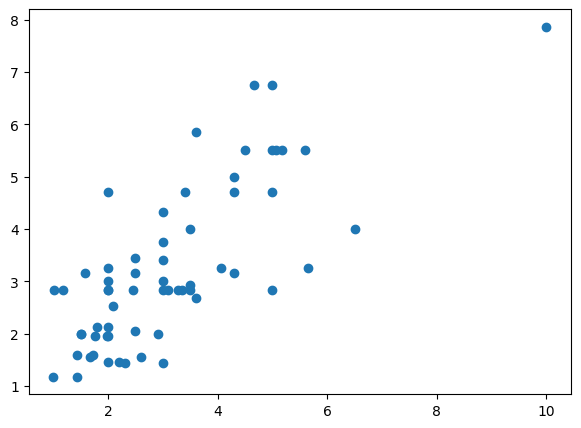

In [13]:
## Build model
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train, max_depth = 7, min_size = 5)
y_test_hat = tree.predict(X_test)

## Visualize predictions
if __name__ == '__main__':
    fig, ax = plt.subplots(figsize = (7, 5))
    plt.scatter(y_test,tree.predict(X_test))
#     ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'Test Sample $y$ vs. $\hat{y}$')
    plt.show

In [4]:
## Loss Functions
import numpy as np 
def gini_index(y):

    size = len(y)
    classes, counts = np.unique(y, return_counts = True)
    pmk = counts/size
    return np.sum(pmk*(1-pmk))
     
def cross_entropy(y):
    size = len(y)
    classes, counts = np.unique(y, return_counts = True)
    pmk = counts/size
    return -np.sum(pmk*np.log2(pmk))

def split_loss(child1, child2, loss = cross_entropy):
    return (len(child1)*loss(child1) + len(child2)*loss(child2))/(len(child1) + len(child2))

## Helper Functions
def all_rows_equal(X):
    return (X == X[0]).all()

def possible_splits(x):
    L_values = []
    for i in range(1, int(np.floor(len(x)/2)) + 1):
        L_values.extend(list(combinations(x, i)))
    return L_values

possible_splits(['a','b','c','d'])

NameError: name 'combinations' is not defined

In [ ]:
class Node:
    
    def __init__(self, Xsub, ysub, ID, obs, depth = 0, parent_ID = None, leaf = True):
        self.Xsub = Xsub
        self.ysub = ysub
        self.ID = ID
        self.obs = obs
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf
        

class Splitter:
    
    def __init__(self):
        self.loss = np.inf
        self.no_split = True
        
    def _replace_split(self, Xsub_d, loss, d, dtype = 'quant', t = None, L_values = None):
        self.loss = loss
        self.d = d
        self.dtype = dtype
        self.t = t
        self.L_values = L_values
        self.no_split = False
        if dtype == 'quant':
            self.L_obs = self.obs[Xsub_d <= t]
            self.R_obs = self.obs[Xsub_d > t]
        else:
            self.L_obs = self.obs[np.isin(Xsub_d, L_values)]
            self.R_obs = self.obs[~np.isin(Xsub_d, L_values)]
        

In [1]:
class DecisionTreeClassifier:
    
    #############################
    ######## 1. TRAINING ########
    #############################
    
    ######### FIT ##########
    def fit(self, X, y, loss_func = cross_entropy, max_depth = 100, min_size = 2, C = None):
        
        ## Add data
        self.X = X
        self.y = y
        self.N, self.D = self.X.shape
        dtypes = [np.array(list(self.X[:,d])).dtype for d in range(self.D)]
        self.dtypes = ['quant' if (dtype == float or dtype == int) else 'cat' for dtype in dtypes]

        ## Add model parameters
        self.loss_func = loss_func
        self.max_depth = max_depth
        self.min_size = min_size
        self.C = C
        
        ## Initialize nodes
        self.nodes_dict = {}
        self.current_ID = 0
        initial_node = Node(Xsub = X, ysub = y, ID = self.current_ID, obs = np.arange(self.N), parent_ID = None)
        self.nodes_dict[self.current_ID] = initial_node
        self.current_ID += 1
        
        # Build
        self._build()

    ###### BUILD TREE ######
    def _build(self):
        
        eligible_buds = self.nodes_dict 
        for layer in range(self.max_depth):
            
            ## Find eligible nodes for layer iteration
            eligible_buds = {ID:node for (ID, node) in self.nodes_dict.items() if 
                                (node.leaf == True) &
                                (node.size >= self.min_size) & 
                                (~all_rows_equal(node.Xsub)) &
                                (len(np.unique(node.ysub)) > 1)}
            if len(eligible_buds) == 0:
                break
            
            ## split each eligible parent
            for ID, bud in eligible_buds.items():
                                
                ## Find split
                self._find_split(bud)
                
                ## Make split
                if not self.splitter.no_split:
                    self._make_split()
                
    ###### FIND SPLIT ######
    def _find_split(self, bud):
        
        ## Instantiate splitter
        splitter = Splitter()
        splitter.bud_ID = bud.ID
        splitter.obs = bud.obs
        
        ## For each (eligible) predictor...
        if self.C is None:
            eligible_predictors = np.arange(self.D)
        else:
            eligible_predictors = np.random.choice(np.arange(self.D), self.C, replace = False)
        for d in sorted(eligible_predictors):
            Xsub_d = bud.Xsub[:,d]
            dtype = self.dtypes[d]
            if len(np.unique(Xsub_d)) == 1:
                continue

            ## For each value...
            if dtype == 'quant':
                for t in np.unique(Xsub_d)[:-1]:
                    ysub_L = bud.ysub[Xsub_d <= t]
                    ysub_R = bud.ysub[Xsub_d > t]
                    loss = split_loss(ysub_L, ysub_R, loss = self.loss_func)
                    if loss < splitter.loss:
                        splitter._replace_split(Xsub_d, loss, d, 'quant', t = t)
            else:
                for L_values in possible_splits(np.unique(Xsub_d)):
                    ysub_L = bud.ysub[np.isin(Xsub_d, L_values)]
                    ysub_R = bud.ysub[~np.isin(Xsub_d, L_values)]
                    loss = split_loss(ysub_L, ysub_R, loss = self.loss_func)
                    if loss < splitter.loss: 
                        splitter._replace_split(Xsub_d, loss, d, 'cat', L_values = L_values)
                        
        ## Save splitter
        self.splitter = splitter
    
    ###### MAKE SPLIT ######
    def _make_split(self):
        
        ## Update parent node
        parent_node = self.nodes_dict[self.splitter.bud_ID]
        parent_node.leaf = False
        parent_node.child_L = self.current_ID
        parent_node.child_R = self.current_ID + 1
        parent_node.d = self.splitter.d
        parent_node.dtype = self.splitter.dtype
        parent_node.t = self.splitter.t        
        parent_node.L_values = self.splitter.L_values
        parent_node.L_obs, parent_node.R_obs = self.splitter.L_obs, self.splitter.R_obs
        
        ## Get X and y data for children
        if parent_node.dtype == 'quant':
            L_condition = parent_node.Xsub[:,parent_node.d] <= parent_node.t
        else:
            L_condition = np.isin(parent_node.Xsub[:,parent_node.d], parent_node.L_values)
        Xchild_L = parent_node.Xsub[L_condition]
        ychild_L = parent_node.ysub[L_condition]
        Xchild_R = parent_node.Xsub[~L_condition]
        ychild_R = parent_node.ysub[~L_condition]
        
        ## Create child nodes
        child_node_L = Node(Xchild_L, ychild_L, obs = parent_node.L_obs, depth = parent_node.depth + 1,
                            ID = self.current_ID, parent_ID = parent_node.ID)
        child_node_R = Node(Xchild_R, ychild_R, obs = parent_node.R_obs, depth = parent_node.depth + 1,
                            ID = self.current_ID+1, parent_ID = parent_node.ID)
        self.nodes_dict[self.current_ID] = child_node_L
        self.nodes_dict[self.current_ID + 1] = child_node_R
        self.current_ID += 2
                
            
    #############################
    ####### 2. PREDICTING #######
    #############################
    
    ###### LEAF MODES ######
    def _get_leaf_modes(self):
        self.leaf_modes = {}
        for node_ID, node in self.nodes_dict.items():
            if node.leaf:
                values, counts = np.unique(node.ysub, return_counts=True)
                self.leaf_modes[node_ID] = values[np.argmax(counts)]
    
    ####### PREDICT ########
    def predict(self, X_test):
        
        # Calculate leaf modes
        self._get_leaf_modes()
        
        yhat = []
        for x in X_test:
            node = self.nodes_dict[0] 
            while not node.leaf:
                if node.dtype == 'quant':
                    if x[node.d] <= node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
                else:
                    if x[node.d] in node.L_values:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
            yhat.append(self.leaf_modes[node.ID])
        return np.array(yhat)
            

NameError: name 'cross_entropy' is not defined